In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file'

Mounted at /content/drive
/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.impute import SimpleImputer
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction
import re

In [3]:
reviews = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)

In [ ]:
reviews.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'], inplace=True)
reviews['Id'] = reviews.index
reviews = reviews.drop(columns=['image', 'style'], axis=1)
reviews['vote'] = np.where(reviews['vote'] != reviews['vote'], -1, reviews['vote'])
reviews['vote'] = np.where(reviews['vote'].str.isdigit(), reviews['vote'], -1)
reviews['reviewText'] = np.where(reviews['reviewText'] != reviews['reviewText'], 'no comment', reviews['reviewText'])
reviews['Upvote'] = pd.cut(reviews['vote'].astype('int'), bins = [-1, 0, 100, 400, 700, 1000], labels = ['Empty', '0-100', '100-400', '400-700', '700-1000'], include_lowest = True)
reviews

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,Id,Upvote
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,-1,0,Empty
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,-1,1,Empty
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,-1,2,Empty
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,-1,3,Empty
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,-1,4,Empty
...,...,...,...,...,...,...,...,...,...,...,...,...
1143855,5,True,"09 8, 2017",A223YRQH2Z5T1D,B01HJF6FRA,flint5292,"As a new vegan, it is sometimes difficult to r...","As a new vegan, it is sometimes difficult to ...",1504828800,4,1143855,0-100
1143856,5,True,"08 4, 2017",A38GDA4TB9EILT,B01HJF6FRA,Moriah Bolyard,The best thing ever is ordering a product you ...,The best thing ever is ordering a product you ...,1501804800,3,1143856,0-100
1143857,5,True,"07 4, 2017",A2025PN7HDC5BO,B01HJF6FRA,M.C,I used to love ranch before I became vegan. It...,Just what the vegan ordered!,1499126400,5,1143857,0-100
1143858,5,True,"06 7, 2017",A1NY7XWC7EPQOA,B01HJF6FRA,Greensboro,I cannot have dairy nor gluten. This is as cl...,This is as close to Ranch as I will ever be ab...,1496793600,2,1143858,0-100


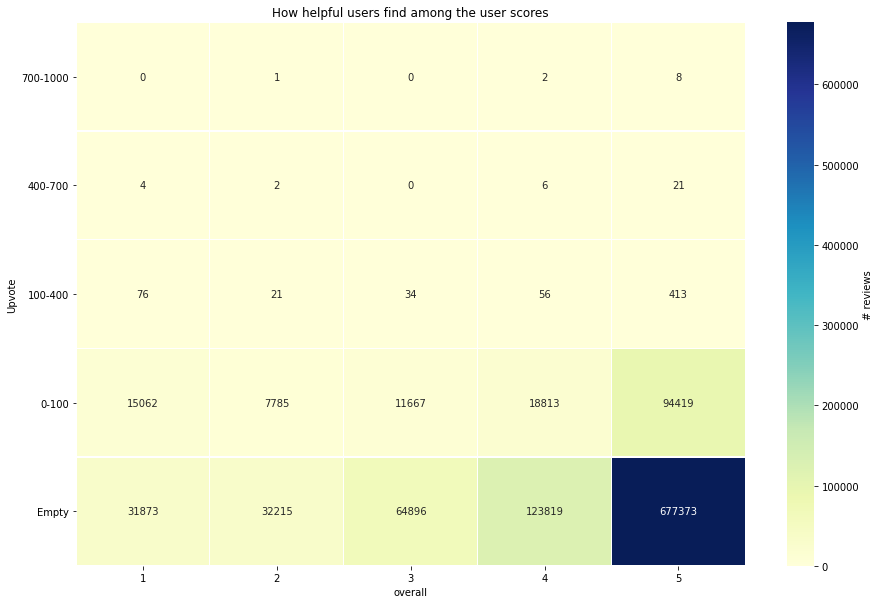

In [ ]:
df_s = reviews.groupby(['overall', 'Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among the user scores')
plt.show()

In [ ]:
df =  reviews[reviews['overall'] != 3]
X = df['reviewText']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['overall'].map(y_dict)

In [ ]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 113703
# train records: 751476
# test records: 250493


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.9514277844091452

-Top 20 positive-
       Word  Coefficient
 pleasantly     4.247913
  addicting     3.853736
   downside     3.615210
        yum     3.478350
     delish     3.424114
     divine     3.139832
   heavenly     2.843143
       haha     2.839059
      fence     2.794222
  excellent     2.732281
  delighted     2.715589
      yummy     2.694016
       yumm     2.675058
   soothing     2.564733
  questions     2.557494
  delicious     2.539539
    awesome     2.529756
     pizzas     2.488306
    perfect     2.468284
     hooked     2.459252

-Top 20 negative-
           Word  Coefficient
    disapointed    -3.012999
          worst    -3.070538
     overwhelms    -3.159208
      deceiving    -3.227140
            yuk    -3.262812
      worthless    -3.310655
          ruins    -3.329775
      deceptive    -3.341418
  disappointing    -3.378149
           bleh    -3.386746
       mediocre    -3.415255
      cancelled    -3.486041
 disappointment    -3.533

In [ ]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 113703
# train records: 751476
# test records: 250493


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.9544218800525364

-Top 20 positive-
       Word  Coefficient
      great    12.230013
  delicious    12.140235
    perfect    10.295324
  excellent     9.916803
       best     9.253002
       love     8.872819
       nice     7.956661
  wonderful     7.938204
    awesome     7.633727
      yummy     7.624326
    amazing     7.464802
      loves     6.599255
        yum     6.547505
  fantastic     6.536382
     highly     6.361571
       good     6.232318
   favorite     6.218175
 pleasantly     6.052488
      works     5.901358
     hooked     5.847041

-Top 20 negative-
           Word  Coefficient
       inedible    -5.849068
       returned    -5.895683
          stale    -5.926003
         refund    -6.102226
       mediocre    -6.132704
          gross    -6.280711
           poor    -6.435716
         return    -6.443685
          hopes    -6.585081
          threw    -6.703485
   disappointed    -7.032270
     disgusting    -7.044431
           yuck    -7.528

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 4123432
# train records: 751476
# test records: 250493


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.9558151325585944

-Top 20 positive-
             Word  Coefficient
        delicious    16.834709
            great    15.545580
             best    14.544735
          perfect    13.941819
             love    13.342428
        excellent    12.467197
             nice    12.061900
        wonderful    10.263829
            yummy    10.214310
          awesome     9.724177
          amazing     9.624597
         favorite     8.985220
            loves     8.771229
        fantastic     8.615266
            works     8.324060
 won disappointed     8.146427
              yum     7.917500
             easy     7.752170
       just right     7.652493
          pleased     7.480584

-Top 20 negative-
           Word  Coefficient
           poor    -8.258809
  unfortunately    -8.343588
          sorry    -8.442446
         refund    -8.834457
          threw    -9.074342
          gross    -9.219966
         return    -9.662146
           weak    -9.664131
          bland

In [ ]:
df = df[df['overall'] == 5]
df = df[df['Upvote'].isin(['0-100', '100-400', '400-700', '700-1000'])]
df.shape

X = df['reviewText']
y_dict = {'0-100': 0, '100-400': 1, '400-700': 1, '700-1000': 1}
y = df['Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
0.0    94419
1.0      442
Name: Upvote, dtype: int64


In [ ]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['Upvote'] == 1])
Downvote_indices = np.array(df_s[df_s['Upvote'] == 1].index)

Upvote_indices = df_s[df_s['Upvote'] == 0].index
random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['reviewText']
under_sample_data['Upvote'] = under_sample_data['Upvote'].astype(int)
y_u = under_sample_data['Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['Upvote'] == 0])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['Upvote'] == 1])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  884


In [ ]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 9987
# train records: 663
# test records: 221
Model Accuracy: 0.7873303167420814

-Top 20 positive-
        Word  Coefficient
         fun     0.883103
       thank     0.758151
         let     0.711930
       helps     0.684621
        took     0.680911
       sugar     0.662427
        malt     0.648637
        skin     0.647809
       color     0.634047
     coconut     0.625830
        milk     0.613165
       honey     0.606284
      unique     0.597049
        live     0.594782
         mid     0.573098
      helped     0.568005
        type     0.560457
          ve     0.544360
 tablespoons     0.534620
       blood     0.531232

-Top 20 negative-
       Word  Coefficient
      grain    -0.357902
    italian    -0.360508
       home    -0.368191
 especially    -0.373468
       saut    -0.374461
       easy    -0.378928
      syrup    -0.383854
    english    -0.384617
 chocolates    -0.401598
      yacon    -0.412666
       ones    -0.424260
    perfect    -0.42943

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 74731
# train records: 663
# test records: 221
Model Accuracy: 0.7782805429864253

-Top 20 positive-
        Word  Coefficient
     coconut     1.531362
       sugar     1.343346
         tea     1.063008
          ve     0.905236
        milk     0.851135
        chia     0.749230
       honey     0.739239
         cup     0.736515
        like     0.712226
       water     0.688894
      powder     0.681500
       seeds     0.657299
     noodles     0.612461
 coconut oil     0.599777
         oil     0.598299
        salt     0.578548
      yogurt     0.573668
       blood     0.548787
         let     0.547804
       flour     0.546116

-Top 20 negative-
       Word  Coefficient
        tin    -0.285865
    italian    -0.297151
   frosting    -0.302300
 chocolates    -0.305867
       best    -0.308372
      quick    -0.313811
       rice    -0.313867
 just right    -0.319670
   good don    -0.328638
     flavor    -0.341847
    texture    -0.352180
   flavored    -0.3558

In [ ]:
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['Upvote']==0]['reviewText'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['Upvote']==1]['reviewText'].iloc[:100:20])

Downvote score 5 comments examples:
466843    I have now subscribed to this product in my se...
519034    Soaks right into your skin; one note:  if you ...
406731    I got a sample of this cereal directly from Ka...
352728    I cooked these in my Instant Pot and made humm...
45049     Lipton Decaffeinated Tea is the perfect thing ...
Name: reviewText, dtype: object
Upvote score 5 comments examples
1005      "On this lovely day, me and my war boys are co...
37355     I'm a green tea fanatic, and have tried over 1...
77977     Haribo quality, awesome price.  Arrived and we...
114336    UPDATE  - I heard that Muir Glen had started t...
163087    Much has been written about how great this pro...
Name: reviewText, dtype: object


In [ ]:
under_sample_data['word_count'] = under_sample_data['reviewText'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['Upvote', 'reviewText'])]
y_num = under_sample_data['Upvote']

Upvote                    0           1
word_count        91.443439  295.882353
capital_count     14.339367   47.081448
question_mark      0.076923    0.484163
exclamation_mark   0.873303    1.400452
punctuation       16.314480   60.144796


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.8099547511312217
SVM accuracy: 0.7963800904977375


In [ ]:
df_user = reviews.groupby(['reviewerID']).agg({'overall':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Rating count', 'Rating mean']
df_user = df_user.sort_values(by = 'Rating count', ascending = False)
print(df_user.head(10))

                Rating count  Rating mean
reviewerID                               
A1LACH6MLQWZ             536     4.934701
A2GJX2KCUSR0EI           406     4.386700
A1GQAKL9CGQLP1           394     4.502538
A2C9XE9I8RSKNX           360     4.330556
A2XKJ1KX6XUHYP           340     3.876471
A2MNB77YGJ3CN0           278     4.607914
AY12DBB0U420B            258     4.565891
A281NPSIMI1C2R           251     4.681275
A2GI8X394RLF83           247     4.255061
A16DZZ68DLRDKP           246     4.837398


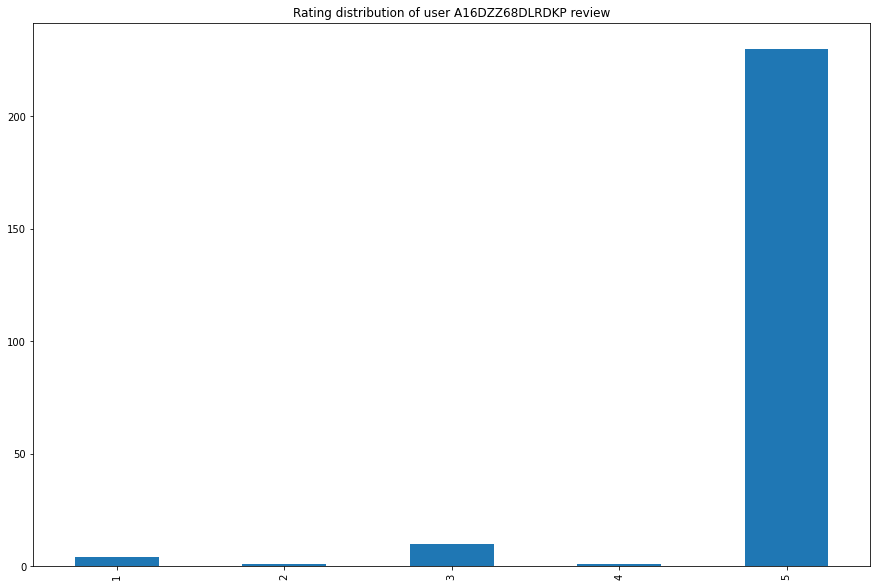

In [ ]:
def plot_user(reviewerID):
    df_1user = reviews[reviews['reviewerID'] == reviewerID]['overall']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Rating distribution of user {} review'.format(reviews[reviews['reviewerID'] == reviewerID]['reviewerID'].iloc[0]))
    plt.show()

plot_user('A16DZZ68DLRDKP')

In [ ]:
print(df_user[(df_user['Rating mean']<3.5) & (df_user['Rating mean']>2.5)].head())

                Rating count  Rating mean
reviewerID                               
A3CP9LMG5SM5KK           120     3.266667
A2S696CI415O20           113     3.221239
A35WGVT8AUEODN            92     3.369565
A15R7AS2ZDB0RK            87     2.954023
A2XNJJ9TF70P4J            73     2.835616


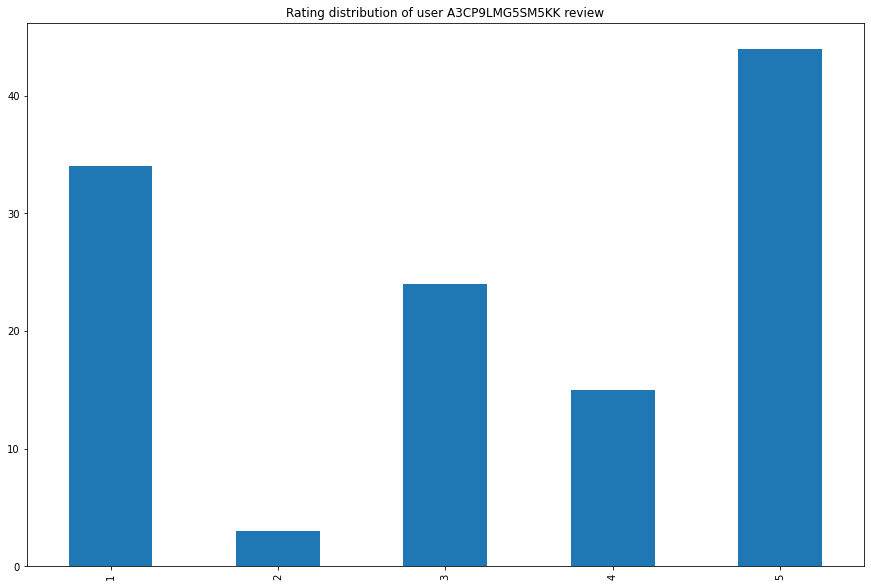

In [ ]:
plot_user('A3CP9LMG5SM5KK')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = reviews[(reviews['reviewerID'] == userid) & (reviews['overall'] == score)]['reviewText']
    else:
        df = reviews[reviews['overall'] == score]['reviewText']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2P739KOM4U5JB')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    #test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
Empty DataFrame
Columns: []
Index: []
score 2 reviews most popular 2-gram / 3-gram:
   Count Occur %           Phrase
0    3.0   30.0%     (candy, bar)
1    3.0   30.0%   (bacon, jerky)
2    3.0   30.0%  (flavor, great)
score 3 reviews most popular 2-gram / 3-gram:
   Count Occur %                  Phrase
0    7.0   70.0%           (taste, like)
1    6.0   60.0%          (fruit, snack)
2    3.0   30.0%  (suppose, taste, like)
3    3.0   30.0%        (suppose, taste)
score 4 reviews most popular 2-gram / 3-gram:
Empty DataFrame
Columns: []
Index: []
score 5 reviews most popular 2-gram / 3-gram:
   Count Occur %            Phrase
0    8.0  42.11%    (gluten, free)
1    5.0  26.32%  (peanut, butter)


In [ ]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5299.0  11.27%   (taste, like)
1  1607.0   3.42%  (waste, money)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %         Phrase
0  3658.0   9.14%  (taste, like)
1  1910.0   4.77%    (n't, like)
2  1342.0   3.35%   (n't, taste)
3  1307.0   3.27%     (n't, buy)
4  1289.0   3.22%  (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %         Phrase
0  4232.0   5.53%  (taste, like)
1  2834.0    3.7%  (taste, good)
score 4 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5732.0   4.02%   (taste, good)
1  5164.0   3.62%   (taste, like)
2  4536.0   3.18%  (pretty, good)
score 5 reviews most popular 2-gram / 3-gram:
     Count Occur %          Phrase
0  23832.0   3.09%  (taste, great)


In [ ]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = reviews[(reviews['reviewerID'] == userid) & (reviews['overall'] == score)]['reviewText']
    else:
        df = reviews[reviews['overall'] == score]['reviewText']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [ ]:
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2P739KOM4U5JB')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    # test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
Empty DataFrame
Columns: []
Index: []
score 2 reviews most popular adjectives word:
   Count Occur % Phrase
0   11.0  110.0%  great
1    7.0   70.0%   good
2    4.0   40.0%   rich
score 3 reviews most popular adjectives word:
   Count Occur %    Phrase
0    8.0   80.0%    little
1    8.0   80.0%     great
2    7.0   70.0%      good
3    5.0   50.0%      nice
4    4.0   40.0%      much
5    3.0   30.0%   perfect
6    3.0   30.0%     light
7    3.0   30.0%  couscous
8    3.0   30.0%   texture
score 4 reviews most popular adjectives word:
    Count Occur %    Phrase
0    13.0  86.67%      good
1    12.0   80.0%     great
2     8.0  53.33%    little
3     7.0  46.67%      easy
4     6.0   40.0%      nice
5     5.0  33.33%  favorite
6     5.0  33.33%       old
7     5.0  33.33%      rich
8     4.0  26.67%   perfect
9     4.0  26.67%     happy
10    4.0  26.67%  couscous
score 5 reviews most popular adjectives word:
   Count Occur %   Phrase
0   